# LSE Sex Survey 2026 Analysis

Complete analysis pipeline producing organized visualizations and statistics.

## Configuration

**Edit these to customize appearance:**

In [1]:
THEME_COLORS = {
    'valentine': ['#C9184A', '#FF4D6D', '#FF758F', '#FF8FA3', '#FFCCD5'],
    'neutral_dark': '#2B2D42',
    'neutral_mid': '#8D99AE',
    'neutral_light': '#F1FAEE'
}

QUALITATIVE_PALETTE = THEME_COLORS['valentine'] 

TYPOGRAPHY = {
    'font_family': 'Georgia, Times New Roman, serif',
    'title_size': 24,
    'subtitle_size': 14,
    'label_size': 13
}

OUTPUT_CONFIG = {
    'base_dir': 'results',
    'summary_stats': 'summary_statistics',
    'bar_charts': 'bar_charts',
    'faceted_charts': 'faceted_charts',
    'wordclouds': 'wordclouds',
    'decision_trees': 'decision_trees',
    'sankey': 'flow_diagrams',
    'diverging': 'diverging_charts',
    'heatmaps':'heatmaps'
}

ANALYSIS_PARAMS = {
    'min_group_size': 5,
    'max_groups_display': 20,
    'tree_max_depth_short': 5,
    'tree_max_depth_long': 8,
    'tree_min_samples_leaf': 7,
    'wordcloud_min_tokens': 40,
    'random_state': 42
}

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import warnings
from wordcloud import WordCloud
from tree_utils import *
from utils import *

pio.kaleido.scope.default_format = "png"
warnings.filterwarnings('ignore')

for subdir in OUTPUT_CONFIG.values():
    os.makedirs(os.path.join(OUTPUT_CONFIG['base_dir'], subdir), exist_ok=True)

print("Output directories created")

Output directories created


## Key Functions

In [3]:
def save_plotly(fig, stem, subdir):
    stem = re.sub(r'[^a-z0-9]+', '_', stem.strip().lower()).strip('_')
    path = os.path.join(OUTPUT_CONFIG['base_dir'], subdir, f'{stem}.html')
    fig.write_html(path, include_plotlyjs='cdn')

def save_matplotlib(fig, stem, subdir):
    stem = re.sub(r'[^a-z0-9]+', '_', stem.strip().lower()).strip('_')
    path = os.path.join(OUTPUT_CONFIG['base_dir'], subdir, f'{stem}.png')
    fig.savefig(path, dpi=220, bbox_inches='tight')

def apply_theme(fig, title, subtitle=None, height=560, show_legend=False):
    fig.update_layout(
        template='plotly_white',
        height=height,
        margin=dict(l=70, r=35, t=80, b=75),
        title=dict(
            text=f"<span style='font-size:{TYPOGRAPHY['title_size']}px; font-weight:700; color:{THEME_COLORS['neutral_dark']}'>{title}</span>" +
                 (f"<br><span style='font-size:{TYPOGRAPHY['subtitle_size']}px; color:{THEME_COLORS['neutral_mid']}'>{subtitle}</span>" if subtitle else ""),
            x=0.02, xanchor='left'
        ),
        font=dict(family=TYPOGRAPHY['font_family'], size=TYPOGRAPHY['label_size'], color=THEME_COLORS['neutral_dark']),
        showlegend=show_legend
    )
    fig.update_xaxes(showgrid=False, linecolor=THEME_COLORS['neutral_dark'])
    fig.update_yaxes(showgrid=True, gridcolor=THEME_COLORS['neutral_light'], linecolor=THEME_COLORS['neutral_dark'])
    return fig

ACCOM_SHORT = {'Urbanest Westminster Bridge': 'Urbanest', 'Garden Halls': 'Garden Halls',
               'Rosebery Hall': 'Rosebery', 'High Holborn': 'High Holborn',
               'Carr-Saunders Hall': 'Carr Saunders', 'Carr Saunders Hall': 'Carr Saunders'}

DEPT_SHORT = {'International Relations': 'IR', 'Geography and Environment': 'Geography',
              'Language Centre': 'Languages', 'Psychological and Behavioural Science': 'Psychology',
              'Pyschological and Behavioural Science': 'Psychology', 'Language Centre':'Languages'}

def standardize_groups(d):
    d = d.copy()
    if 'lse_accommodation' in d.columns:
        d['lse_accommodation'] = d['lse_accommodation'].replace(ACCOM_SHORT)
    if 'department' in d.columns:
        d['department'] = d['department'].replace(DEPT_SHORT)
    if 'gender' in d.columns:
        d['gender'] = d['gender'].replace({'Male': 'Men', 'Female': 'Women'})
    return d

## Load and Clean Data

In [4]:
survey = pd.read_csv('survey.csv')
survey = survey[2:]
survey.columns = survey.columns.str.strip()
survey = survey.drop(columns=['StartDate', 'EndDate', 'Status', 'Progress',
                              'DistributionChannel', 'UserLanguage', 'Finished'])
survey['Duration (in seconds)'] = pd.to_numeric(survey['Duration (in seconds)'], errors='coerce')

print(f"Initial: {len(survey)}")
survey = survey[survey['Q_DuplicateRespondent'] != 'true']
print(f"After deduplication: {len(survey)}")

Initial: 275
After deduplication: 264


## Rename Columns

In [5]:
rename_dict = {
    'Q1': 'year_of_study', 'Q2': 'lse_accommodation', 'Q3': 'department',
    'Q4': 'society_or_sports_team', 'Q5': 'is_virgin', 'Q6': 'body_count',
    'Q8': 'sexuality', 'Q8_5_TEXT': 'sexuality_other_text',
    'Q9': 'gender', 'Q9_4_TEXT': 'gender_other_text',
    'Q10': 'sex_positions_tried', 'Q10_8_TEXT': 'sex_positions_tried_other_text',
    'Q11': 'favourite_sex_position', 'Q11_8_TEXT': 'favourite_sex_position_other_text',
    'Q12': 'had_sex_on_campus', 'Q13': 'sex_on_campus_location',
    'Q14': 'kinks_participated', 'Q14_9_TEXT': 'kinks_other_text',
    'Q15': 'sex_frequency', 'Q16': 'had_same_gender_sex',
    'Q17': 'relationship_status', 'Q18': 'number_of_regular_sexual_partners',
    'Q19': 'masturbation_frequency', 'Q20': 'watches_porn',
    'Q21': 'porn_genres_watched', 'Q21_13_TEXT': 'porn_genres_other_text',
    'Q22': 'has_cheated', 'Q23': 'has_been_cheated_on',
    'Q24': 'had_std', 'Q25': 'std_type', 'Q26': 'had_threesome',
    'Q27': 'max_partners_at_once', 'Q28': 'hooked_up_with_sway',
    'Q29': 'dating_apps_used', 'Q29_6_TEXT': 'dating_apps_other_text'
}
survey = survey.rename(columns=rename_dict)

## Process Multi-Select Columns

In [6]:
multi_cols = ['sex_positions_tried', 'kinks_participated', 'porn_genres_watched', 'dating_apps_used']

for col in multi_cols:
    dummies = survey[col].fillna('').str.get_dummies(sep=',')
    dummies.columns = [f'{col}__' + c.strip().lower().replace(' ', '_') for c in dummies.columns if c.strip()]
    survey = survey.join(dummies)

print(f"Processed {len(multi_cols)} multi-select columns")

Processed 4 multi-select columns


## Process Society Data

In [7]:
def split_multi_entry(value):
    if pd.isna(value):
        return []

    s = str(value).strip()
    s = re.sub(r'\s+', ' ', s)

    none_like = {'no', 'n/a', 'na', 'non', 'none', '-', '/', 'secret', 'naa'}
    if s.lower() in none_like:
        return []

    # normalize separators to commas
    s = re.sub(r'(\n|/|;|\|)', ',', s)
    s = re.sub(r'\s*&\s*', ',', s)
    s = re.sub(r'\s+and\s+', ',', s, flags=re.I)

    parts = [p.strip() for p in s.split(',') if p.strip()]
    return parts


def canonicalize_society(token):
    t = str(token).strip().lower()
    t = re.sub(r'\s+', ' ', t)
    t_clean = re.sub(r"[^\w\s']", '', t).strip()
    if t_clean in {'', 'lse', 'lsesu'}:
        return None
    synonym_map = {
        'beaver': 'Beaver',
        'the beaver': 'Beaver',
        'lsesu beaver': 'Beaver',

        'womens rugby': "Women's Rugby",
        'women’s rugby': "Women's Rugby",
        'rugby': 'Rugby',
        'women’s football': "Women's Football",
        'womens football': "Women's Football",
        'women’s basketball': "Women's Basketball",
        'womens basketball': "Women's Basketball",

        'tennis': 'Tennis',
        'padel': 'Squash and Padel',
        'squash': 'Squash and Padel',
        'netball': 'Netball',
        'rowing': 'Rowing',
        'swimming': 'Swimming',
        'cricket': 'Cricket',
        'baseball': 'Baseball',
        'lacrosse': 'Lacrosse',
        'american football': 'American Football',
        'futsal': 'Futsal',
        'basketball': 'Basketball',
        'boxing': 'Boxing',
        'muay thai': 'Muay Thai',
        'jiu jitsu': 'Jiu Jitsu',
        'climbing': 'Climbing',
        'surf': 'Surf',
        'snow sports': 'Snow Sports',
        'ski': 'Snow Sports',
        'snow': 'Snow Sports',

        'pilates': 'Pilates',
        'yoga': 'Yoga',
        'yoga society': 'Yoga',
        'pole': 'Pole',
        'pole fitness': 'Pole',

        'economics society': 'Academic Society',
        'big': 'Pre Professional Society',
        'govsoc': 'GovSoc',
        'government society': 'GovSoc',
        'consulting sociefy': 'Pre Professional Society',
        'consulting society': 'Pre Professional Society',
        'accounting soc': 'Academic Society',
        'women in politics': 'Pre Professional Society',

        'israeli society': 'Socio-Cultural Society',
        'india society': 'Socio-Cultural Society',
        'singapore': 'Socio-Cultural Society',
        'singapore society': 'Socio-Cultural Society',
        'malayali society': 'Socio-Cultural Society',
        'filsoc': 'Socio-Cultural Society',
        'northern': 'Socio-Cultural Society',

        'music': 'Music Society',
        'choir': 'Music Society',
        'drama': 'Drama',
        'debate': 'Debate',
        'loose tv': 'Loose TV',

        'cds': 'Other',
        'kcsoc': 'Other',
        'hkpass': 'Other',
    }

    if t_clean in synonym_map:
        return synonym_map[t_clean]
    return t_clean.title()

def build_society_list(series):
    out = []
    for v in series:
        raw_tokens = split_multi_entry(v)
        canon = []
        for tok in raw_tokens:
            c = canonicalize_society(tok)
            if c is not None and c not in canon:
                canon.append(c)
        out.append(canon)
    return out

def to_snake_case_label(s):
    s = str(s).strip().lower()
    s = re.sub(r'&', 'and', s)
    s = re.sub(r'[^a-z0-9]+', '_', s)
    s = re.sub(r'_+', '_', s).strip('_')
    return s

def add_society_multihot(df, source_col='society_or_sports_team', prefix='soc__'):
    df = df.copy()
    df['society_list'] = build_society_list(df[source_col])
    all_labels = sorted({lab for labs in df['society_list'] for lab in labs})

    new_cols = [f"{prefix}{to_snake_case_label(lab)}" for lab in all_labels]
    soc_dummies = pd.DataFrame(0, index=df.index, columns=new_cols, dtype='int64')

    label_to_col = {lab: f"{prefix}{to_snake_case_label(lab)}" for lab in all_labels}

    for i, labs in enumerate(df['society_list']):
        for lab in labs:
            soc_dummies.loc[df.index[i], label_to_col[lab]] = 1

    df = pd.concat([df, soc_dummies], axis=1)
    return df, new_cols

survey, soc_cols = add_society_multihot(survey)
print(len(soc_cols), 'society columns created')
survey[soc_cols].sum().sort_values(ascending=False).head(20)

81 society columns created


soc__tennis                      11
soc__beaver                       9
soc__dance                        6
soc__socio_cultural_society       5
soc__squash_and_padel             4
soc__pre_professional_society     4
soc__pilates                      4
soc__academic_society             3
soc__boxing                       3
soc__other                        3
soc__music_society                3
soc__climbing                     3
soc__yoga                         3
soc__rugby                        2
soc__swimming                     2
soc__pole                         2
soc__grimshaw                     2
soc__snow_sports                  2
soc__badminton                    2
soc__debate                       2
dtype: int64

## Clean STD Responses

In [8]:
def standardize_std_types(series):
    canon_labels = ['chlamydia', 'gonorrhea', 'herpes', 'hpv', 'hiv_aids']
    patterns = {
        'chlamydia': re.compile(r'\b(chlamy(dia)?|clym(i|y)dia|clam(i|y)dia)\b', re.I),
        'gonorrhea': re.compile(r'\b(gonorr?h?e?a|gonoherra|gonnorhea|clap)\b', re.I),
        'herpes': re.compile(r'\bherpes\b', re.I),
        'hpv': re.compile(r'\b(hpv|vph)\b', re.I),
        'hiv_aids': re.compile(r'\b(hiv|aids)\b', re.I),}
    none_like = {'', '-', 'na', 'n/a', 'none', 'no'}
    clean_lists = []
    for v in series:
        if pd.isna(v):
            clean_lists.append([])
            continue
        raw = str(v).strip()
        raw_norm = re.sub(r'\s+', ' ', raw).strip().lower()
        if raw_norm in none_like:
            clean_lists.append([])
            continue
        found = []
        for label, pat in patterns.items():
            if pat.search(raw_norm):
                found.append(label)

        if len(found) == 0:
            clean_lists.append(['other'])
        else:
            clean_lists.append(sorted(set(found)))

    out = pd.DataFrame({'std_clean_list': clean_lists})

    for lab in canon_labels + ['other']:
        out[f'std__{lab}'] = out['std_clean_list'].apply(lambda lst: int(lab in lst))

    return out

std_out = standardize_std_types(survey['std_type'])
survey = pd.concat([survey, std_out], axis=1)

## Remove Invalid Responses

In [9]:
# 1. asexuals w/ bodies 
asexual_high_bc = (survey['sexuality'].str.lower().str.contains('asexual', na=False)) & (survey['body_count'] != '0')
print(f"Dropping {asexual_high_bc.sum()} responses: Asexual with body count > 0")
survey = survey.loc[~asexual_high_bc].copy()

# 2. virgin w/ bodies 
virgin_with_bc = (survey['is_virgin'] == 'Yes') & (survey['body_count'] != '0')
print(f"Dropping {virgin_with_bc.sum()} responses: Virgin with body count > 0")
survey = survey.loc[~virgin_with_bc].copy()

# virgin w/ sexual partners
virgin_with_partners = (survey['is_virgin'] == 'Yes') & (survey['number_of_regular_sexual_partners'].notna())
print(f"Dropping {virgin_with_partners.sum()} responses: Virgin with regular sexual partners")
survey = survey.loc[~virgin_with_partners].copy()

# virgin w/ frequent sex
virgin_frequent_sex = (survey['is_virgin'] == 'Yes') &  (survey['sex_frequency'].isin(['Once or twice a week', 'Once a month',
       'More than five days a week', 'Multiple times a day', 'Once a day']))
print(f"Dropping {virgin_frequent_sex.sum()} responses: Virgin with frequent sex")
survey = survey.loc[~virgin_frequent_sex].copy()

Dropping 3 responses: Asexual with body count > 0
Dropping 2 responses: Virgin with body count > 0
Dropping 1 responses: Virgin with regular sexual partners
Dropping 0 responses: Virgin with frequent sex


## Save Cleaned Data

In [10]:
survey.to_csv('survey_cleaned.csv')

## Generate Summary Statistics

In [11]:
generate_summary_stats(survey, soc_cols=soc_cols, min_group_size=5, top_k=3)

'results/summary_statistics.txt'

## Create Bar Charts

In [12]:
def create_bar_charts(df):
    d = standardize_groups(df)
    color_idx = [0]
    
    def yesno_bar(group_col, var, title):
        sub = d.dropna(subset=[group_col, var]).copy()

        if group_col == 'sexuality':
            sub = sub[sub['sexuality'].isin(['Straight', 'Gay', 'Bisexual'])]

        sizes = sub[group_col].value_counts()
        keep = sizes[sizes >= ANALYSIS_PARAMS['min_group_size']].index
        sub = sub[sub[group_col].isin(keep)]

        if sub.empty:
            return

        rates = (
            sub.groupby(group_col)[var]
            .apply(lambda x: (x == 'Yes').mean() * 100)
            .reset_index(name='pct')
            .sort_values('pct', ascending=False)
            .head(ANALYSIS_PARAMS['max_groups_display'])
        )

        overall_avg = (sub[var] == 'Yes').mean() * 100
        fig = px.bar(
            rates,
            x=group_col,
            y='pct',
            category_orders={group_col: rates[group_col].tolist()}
        )

        fig.update_traces(
            marker_color=QUALITATIVE_PALETTE[color_idx[0] % len(QUALITATIVE_PALETTE)],
            text=rates['pct'].round(1).astype(str) + '%',
            textposition='outside'
        )
        color_idx[0] += 1

        # add dotted average line
        fig.add_hline(
            y=overall_avg,
            line_dash='dot',
            line_width=2,
            annotation_text=f'Overall avg: {overall_avg:.1f}%',
            annotation_position='top right'
        )

        y_max = max(rates['pct'].max(), overall_avg) * 1.15
        fig.update_yaxes(title_text='Percent (%)', range=[0, max(5, y_max)])
        fig.update_xaxes(title_text='', tickangle=-35 if group_col not in ['gender', 'sexuality'] else 0)

        fig = apply_theme(fig, title, height=520)
        save_plotly(fig, f'{var}_by_{group_col}', OUTPUT_CONFIG['bar_charts'])
        fig.show()

    
    vars_to_plot = [
        ('is_virgin', 'Virginity Rate'),
        ('had_sex_on_campus', 'Had Sex on Campus'),
        ('has_cheated', 'Have Cheated'),
        ('hooked_up_with_sway', 'Hooked Up at Sway')
    ]
    
    for group_col in ['lse_accommodation', 'department', 'gender', 'sexuality']:
        if group_col in d.columns:
            for var, label in vars_to_plot:
                if var in d.columns:
                    yesno_bar(group_col, var, f'{label} by {group_col.replace("_", " ").title()}')

create_bar_charts(survey)

## Create Wordclouds

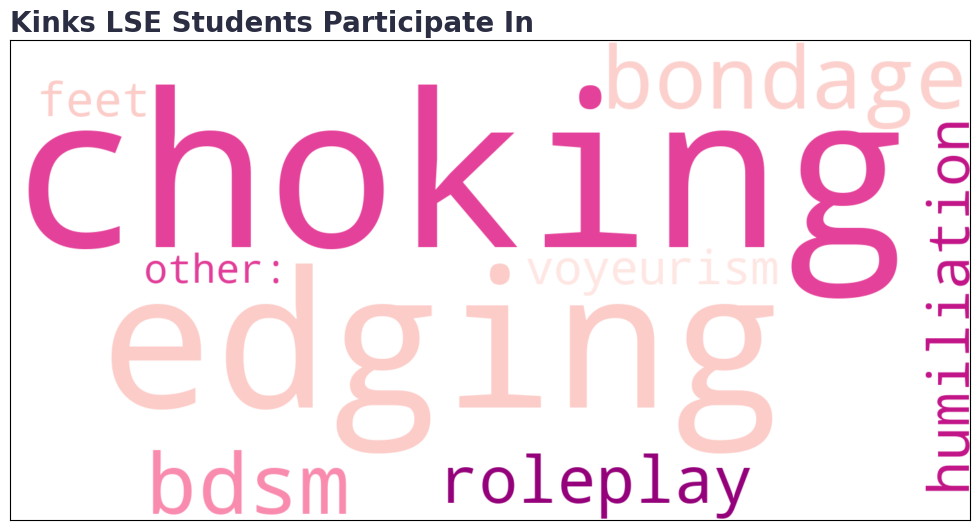

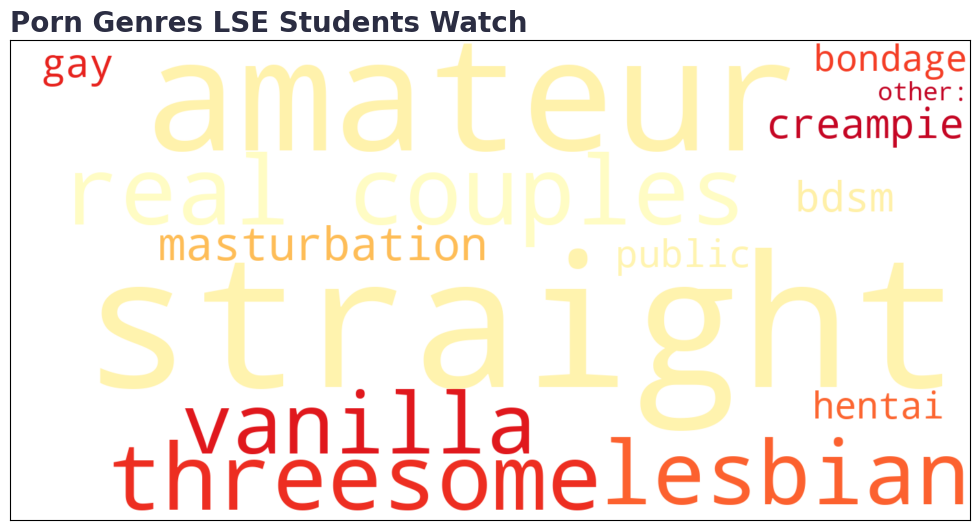

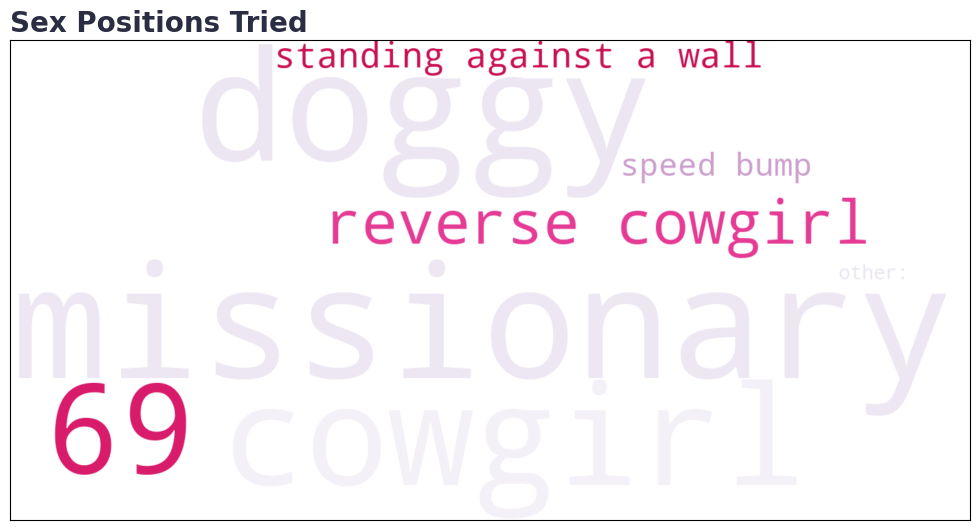

In [13]:
def create_wordclouds(df):
    def tokens_from_multihot(prefix):
        cols = [c for c in df.columns if c.startswith(prefix)]
        if not cols:
            return pd.Series([], dtype=str)
        chosen = df[cols].fillna(0).astype(int).stack()
        chosen = chosen[chosen == 1]
        if chosen.empty:
            return pd.Series([], dtype=str)
        return chosen.index.get_level_values(1).to_series(index=None).str.replace(prefix, '').str.replace('_', ' ')
    
    def draw_wordcloud(tokens, title, cmap):
        if len(tokens) < ANALYSIS_PARAMS['wordcloud_min_tokens']:
            return
        counts = tokens.value_counts()
        wc = WordCloud(width=1400, height=700, background_color='white', colormap=cmap,
                      max_words=100, random_state=ANALYSIS_PARAMS['random_state']).generate_from_frequencies(counts.to_dict())
        
        fig = plt.figure(figsize=(12, 6), facecolor='white')
        ax = fig.add_axes([0.05, 0.1, 0.9, 0.8])
        ax.imshow(wc, interpolation='bilinear')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(title, fontsize=20, fontweight='bold', color=THEME_COLORS['neutral_dark'], loc='left')
        save_matplotlib(fig, title, OUTPUT_CONFIG['wordclouds'])
        plt.show()
    
    draw_wordcloud(tokens_from_multihot('kinks_participated__'), 'Kinks LSE Students Participate In', 'RdPu')
    draw_wordcloud(tokens_from_multihot('porn_genres_watched__'), 'Porn Genres LSE Students Watch', 'YlOrRd')
    draw_wordcloud(tokens_from_multihot('sex_positions_tried__'), 'Sex Positions Tried', 'PuRd')

create_wordclouds(survey)

## Infidelity Gap Charts

In [14]:
for group_col, title in [
    ('department', 'Infidelity by Department'),
    ('gender', 'Infidelity by Gender'),
    ('sexuality', 'Infidelity by Sexuality'),
    ('lse_accommodation', 'Infidelity by Accommodation')
]:
    if group_col not in survey.columns:
        continue
    
    d = standardize_groups(survey)
    fig = create_infidelity_diverging(d, group_col, title, THEME_COLORS, TYPOGRAPHY, QUALITATIVE_PALETTE)
    
    if fig:
        save_plotly(fig, f'infidelity_gap_{group_col}', OUTPUT_CONFIG['diverging'])
        fig.show()

## Faceted Body Count Charts

In [15]:
for facet_col, title in [
    ('gender', 'Body Count by Gender'),
    ('sexuality', 'Body Count by Sexuality'),
    ('department', 'Body Count by Department'),
    ('lse_accommodation', 'Body Count by Accommodation')
]:
    if facet_col in survey.columns:
        d = standardize_groups(survey)
        fig = create_body_count_facet(d, facet_col, title, THEME_COLORS, TYPOGRAPHY, 
                                      QUALITATIVE_PALETTE, min_n=ANALYSIS_PARAMS['min_group_size'])
        if fig:
            save_plotly(fig, f'facet_body_count_{facet_col}', OUTPUT_CONFIG['faceted_charts'])
            fig.show()

## Body Count and Frequency Heatmap

In [16]:
fig = create_heatmap(survey, THEME_COLORS, TYPOGRAPHY, QUALITATIVE_PALETTE)
if fig:
    save_plotly(fig, 'heatmap_bodycount_frequency', OUTPUT_CONFIG['heatmaps'])
    fig.show()

## Faceted Sex Frequency Charts

In [17]:
SEX_FREQ_ORDER = ['Less', 'Once a month', 'Once or twice a week', 
                   'More than five days a week', 'Once a day', 'Multiple times a day']

for facet_col, title in [
    ('gender', 'Sex Frequency by Gender'),
    ('sexuality', 'Sex Frequency by Sexuality'),
    ('department', 'Sex Frequency by Department'),
    ('lse_accommodation', 'Sex Frequency by Accommodation')
]:
    if facet_col in survey.columns and 'sex_frequency' in survey.columns:
        d = standardize_groups(survey)
        fig = create_frequency_facet(d, facet_col, 'sex_frequency', SEX_FREQ_ORDER,
                                    title, THEME_COLORS, TYPOGRAPHY, QUALITATIVE_PALETTE,
                                    min_n=ANALYSIS_PARAMS['min_group_size'])
        if fig:
            save_plotly(fig, f'facet_sex_frequency_{facet_col}', OUTPUT_CONFIG['faceted_charts'])
            fig.show()

## Faceted Masturbation Frequency Charts

In [18]:
MAST_FREQ_ORDER = ["I don't", 'Once a week or less', 'Multiple times a week', 'Once or more a day']

for facet_col, title in [
    ('gender', 'Masturbation Frequency by Gender'),
    ('sexuality', 'Masturbation Frequency by Sexuality')
]:
    if facet_col in survey.columns and 'masturbation_frequency' in survey.columns:
        d = standardize_groups(survey)
        fig = create_frequency_facet(d, facet_col, 'masturbation_frequency', MAST_FREQ_ORDER,
                                    title, THEME_COLORS, TYPOGRAPHY, QUALITATIVE_PALETTE,
                                    min_n=ANALYSIS_PARAMS['min_group_size'])
        if fig:
            save_plotly(fig, f'facet_masturbation_{facet_col}', OUTPUT_CONFIG['faceted_charts'])
            fig.show()

## Decision Trees (demographics)

In [19]:
# Base columns for predictions
base_cols = ['lse_accommodation', 'department', 'gender', 'sexuality',
             'watches_porn', 'has_cheated', 'had_threesome', 'sex_frequency',
             'masturbation_frequency', 'body_count', 'relationship_status']

leaf_styles = get_leaf_styles()

# Helper function to create target variable
def target_yesno(series):
    s = series.astype(str)
    return pd.Series(np.where(s.eq('Yes'), 1, np.where(s.eq('No'), 0, np.nan)), index=series.index)

# Short tree params
params_short = {
    'max_depth': ANALYSIS_PARAMS['tree_max_depth_short'],
    'min_samples_leaf': ANALYSIS_PARAMS['tree_min_samples_leaf'],
    'min_samples_split': ANALYSIS_PARAMS['tree_min_samples_leaf'] * 2,
    'random_state': ANALYSIS_PARAMS['random_state']
}

# Long tree params (for body count)
params_long = {
    'max_depth': ANALYSIS_PARAMS['tree_max_depth_long'],
    'min_samples_leaf': 5,
    'min_samples_split': 10,
    'random_state': ANALYSIS_PARAMS['random_state']
}

print("Decision tree parameters configured")

Decision tree parameters configured


## Virgin Tree

In [20]:
virgin_exclude = {'body_count', 'sex_frequency', 'relationship_status', 'has_cheated',
                  'number_of_regular_sexual_partners', 'favourite_sex_position',
                  'sex_positions_tried', 'kinks_participated', 'had_same_gender_sex',
                  'had_sex_on_campus', 'hooked_up_with_sway', 'had_std', 'had_threesome',
                  'has_been_cheated_on', 'lse_accommodation', 'watches_porn', 'dating_apps_used'}

y = target_yesno(survey['is_virgin'])
clf, features = train_binary_tree(survey, y, base_cols, virgin_exclude, params_short)

if clf:
    fig = tree_to_figure_binary(clf, features, "Can we guess if you're a virgin?",
                                leaf_styles['virgin'], THEME_COLORS, TYPOGRAPHY, 
                                QUALITATIVE_PALETTE, height=800)
    save_plotly(fig, 'tree_virgin_prediction', OUTPUT_CONFIG['decision_trees'])
    fig.show()

## Relationship Status Prediction Tree

In [21]:
relationship_exclude = {'relationship_status', 'number_of_regular_sexual_partners',
                        'sex_frequency', 'masturbation_frequency', 'body_count',
                        'is_virgin', 'sex_positions_tried', 'dating_apps_used'}

def target_relationship(d):
    s = d['relationship_status'].astype(str)
    return pd.Series(
        np.where(s.eq('Yes'), 1, 
                np.where(s.isin(['No', "It's complicated"]), 0, np.nan)),
        index=d.index
    )

y = target_relationship(survey)
clf, features = train_binary_tree(survey, y, base_cols, relationship_exclude, params_short)

if clf:
    fig = tree_to_figure_binary(clf, features, "Can we guess if you're in a relationship?",
                                leaf_styles['taken'], THEME_COLORS, TYPOGRAPHY, 
                                QUALITATIVE_PALETTE, height=820)
    save_plotly(fig, 'tree_relationship_prediction', OUTPUT_CONFIG['decision_trees'])
    fig.show()

## Been Cheated On Prediction Tree

In [22]:
cheated_on_exclude = {'has_been_cheated_on', 'sex_positions_tried'}

y = target_yesno(survey['has_been_cheated_on'])
clf, features = train_binary_tree(survey, y, base_cols, cheated_on_exclude, params_short)

if clf:
    fig = tree_to_figure_binary(clf, features, "Can we guess if you've been cheated on?",
                                leaf_styles['cheated'], THEME_COLORS, TYPOGRAPHY, 
                                QUALITATIVE_PALETTE, height=980)
    save_plotly(fig, 'tree_cheated_on_prediction', OUTPUT_CONFIG['decision_trees'])
    fig.show()

## Body Count Decision Tree

In [23]:
# Multiclass tree for body count prediction
BC_ORDER = ['0', '1', '2', '3-5', '5-10', '10-20', '20-50', '50-100', '100+']

bodycount_exclude = {'body_count', 'is_virgin', 'relationship_status',
                    'sex_positions_tried', 'sex_frequency', 'number_of_regular_sexual_partners'}

def target_body_count(d):
    s = d['body_count'].astype(str)
    return pd.Series(np.where(s.isin(BC_ORDER), s, np.nan), index=d.index)

d = survey.copy()
d['_y_'] = target_body_count(d)
d = d.dropna(subset=['_y_']).copy()

base_use = [c for c in base_cols if c in d.columns and c not in bodycount_exclude]
X = build_feature_frame(d, base_use, allow_multihot=True)
X = drop_leakage_columns(X, bodycount_exclude)

if X.shape[1] >= 2 and len(X) >= 15:
    from sklearn.tree import DecisionTreeClassifier
    
    clf = DecisionTreeClassifier(
        max_depth=params_long['max_depth'],
        min_samples_leaf=params_long['min_samples_leaf'],
        min_samples_split=params_long['min_samples_split'],
        random_state=params_long['random_state'],
        class_weight='balanced'
    )
    clf.fit(X, d['_y_'].astype(str))
    
    # Create multiclass tree figure
    from tree_utils import tree_to_figure_binary, collapse_set_for_binary, display_nodes, build_tree_layout
    import plotly.graph_objects as go
    
    # For multiclass, adapt the binary visualization
    t = clf.tree_
    
    # Use simplified collapse for multiclass
    def multiclass_top_class(node_id):
        l = t.children_left[node_id]
        r = t.children_right[node_id]
        if l == r:
            probs = t.value[node_id][0]
            probs = probs / probs.sum() if probs.sum() else probs
            classes = clf.classes_
            return str(classes[int(np.argmax(probs))])
        a = multiclass_top_class(l)
        b = multiclass_top_class(r)
        return a if a == b else "mix"
    
    collapse_nodes = set()
    def find_collapse(node_id):
        l = t.children_left[node_id]
        r = t.children_right[node_id]
        if l == r:
            return multiclass_top_class(node_id)
        a = find_collapse(l)
        b = find_collapse(r)
        if a == b and a != "mix":
            collapse_nodes.add(node_id)
            return a
        return "mix"
    
    find_collapse(0)
    
    keep_nodes, edges = display_nodes(t, collapse_nodes)
    x, y, display_leaves = build_tree_layout(keep_nodes, edges, t, collapse_nodes)
    
    # Build figure similar to binary but with multiclass leaves
    edge_x, edge_y = [], []
    for src, dst, _ in edges:
        edge_x += [x[src], x[dst], None]
        edge_y += [y[src], y[dst], None]
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=edge_x, y=edge_y, mode='lines',
        line=dict(width=3.2, color='rgba(43,45,66,0.20)'),
        hoverinfo='skip', showlegend=False
    ))
    
    def rgba_mc(hex_color, a=0.26):
        h = str(hex_color).lstrip('#')
        rgb = [int(h[i:i+2], 16) for i in (0, 2, 4)]
        return f'rgba({rgb[0]},{rgb[1]},{rgb[2]},{a})'
    
    leaf_color_map = {}
    for i, nid in enumerate(sorted(display_leaves, key=lambda z: x[z])):
        leaf_color_map[nid] = rgba_mc(QUALITATIVE_PALETTE[i % len(QUALITATIVE_PALETTE)])
    
    node_sizes = [30 if nid in display_leaves else 22 for nid in keep_nodes]
    node_colors = [
        leaf_color_map.get(nid, rgba_mc(QUALITATIVE_PALETTE[0])) 
        if nid in display_leaves else 'rgba(43,45,66,0.07)' 
        for nid in keep_nodes
    ]
    
    fig.add_trace(go.Scatter(
        x=[x[nid] for nid in keep_nodes],
        y=[y[nid] for nid in keep_nodes],
        mode='markers',
        marker=dict(size=node_sizes, color=node_colors, line=dict(width=2, color='white')),
        hoverinfo='skip', showlegend=False
    ))
    
    for nid in keep_nodes:
        is_leaf = nid in display_leaves
        if is_leaf:
            probs = t.value[nid][0]
            probs = probs / probs.sum() if probs.sum() else probs
            i = int(np.argmax(probs))
            label = str(clf.classes_[i])
            conf = float(probs[i])
            main = wrap_html(f"Most likely: {label}", max_len=30)
            sub = f"{conf*100:.0f}% confidence"
            bg = leaf_color_map.get(nid, rgba_mc(QUALITATIVE_PALETTE[0]))
        else:
            f_idx = t.feature[nid]
            main = wrap_html(pretty_question(list(X.columns)[f_idx]), max_len=34)
            sub = ""
            bg = 'rgba(255,255,255,0.96)'
        
        txt = f"<b>{main}</b>" + (f"<br><span style='font-size:12px; opacity:0.82'>{sub}</span>" if sub else "")
        
        fig.add_annotation(
            x=float(x[nid]), y=float(y[nid]), text=txt, showarrow=False,
            align='center', xanchor='center', yanchor='middle',
            bgcolor=bg, bordercolor='rgba(43,45,66,0.16)',
            borderwidth=2, borderpad=10,
            font=dict(size=13, family=TYPOGRAPHY['font_family'], color=THEME_COLORS['neutral_dark'])
        )
    
    for src, dst, lab in edges:
        mx = (x[src] + x[dst]) / 2.0
        my = (y[src] + y[dst]) / 2.0
        fig.add_annotation(
            x=float(mx), y=float(my), text=f"<b>{lab}</b>", showarrow=False,
            font=dict(size=12, family=TYPOGRAPHY['font_family'], color=THEME_COLORS['neutral_dark']),
            bgcolor='rgba(255,255,255,0.85)', bordercolor='rgba(43,45,66,0.10)',
            borderwidth=1, borderpad=3
        )
    
    fig.update_layout(
        template='plotly_white', height=920,
        margin=dict(l=30, r=30, t=75, b=20),
        title=dict(
            text="<b>Can we guess your body count?</b>",
            x=0.5, xanchor='center',
            font=dict(size=TYPOGRAPHY['title_size'], family=TYPOGRAPHY['font_family'], 
                     color=THEME_COLORS['neutral_dark'])
        ),
        xaxis=dict(visible=False), yaxis=dict(visible=False),
        paper_bgcolor='white', font=dict(family=TYPOGRAPHY['font_family'])
    )
    
    save_plotly(fig, 'tree_body_count_prediction', OUTPUT_CONFIG['decision_trees'])
    fig.show()

## Additional Yes/No Prediction Trees

In [24]:
# Porn watching prediction
porn_exclude = {'watches_porn', 'porn_genres_watched', 'masturbation_frequency'}
y = target_yesno(survey['watches_porn'])
clf, features = train_binary_tree(survey, y, base_cols, porn_exclude, params_short)

if clf:
    porn_style = {
        "almost": "You almost definitely watch porn",
        "prob": "You probably watch porn",
        "either": "Could go either way",
        "unlikely": "You probably don't watch porn",
        "almost_not": "You almost definitely don't watch porn"
    }
    fig = tree_to_figure_binary(clf, features, "Can we guess if you watch porn?",
                                porn_style, THEME_COLORS, TYPOGRAPHY, 
                                QUALITATIVE_PALETTE, height=800)
    save_plotly(fig, 'tree_porn_prediction', OUTPUT_CONFIG['decision_trees'])
    fig.show()

# Threesome prediction
threesome_exclude = {'had_threesome', 'max_partners_at_once'}
y = target_yesno(survey['had_threesome'])
clf, features = train_binary_tree(survey, y, base_cols, threesome_exclude, params_short)

if clf:
    threesome_style = {
        "almost": "You've almost definitely had a threesome",
        "prob": "You've probably had a threesome",
        "either": "Could go either way",
        "unlikely": "You probably haven't had a threesome",
        "almost_not": "You've almost definitely not had a threesome"
    }
    fig = tree_to_figure_binary(clf, features, "Can we guess if you've had a threesome?",
                                threesome_style, THEME_COLORS, TYPOGRAPHY, 
                                QUALITATIVE_PALETTE, height=800)
    save_plotly(fig, 'tree_threesome_prediction', OUTPUT_CONFIG['decision_trees'])
    fig.show()

# Campus sex prediction
campus_exclude = {'had_sex_on_campus', 'sex_on_campus_location'}
y = target_yesno(survey['had_sex_on_campus'])
clf, features = train_binary_tree(survey, y, base_cols, campus_exclude, params_short)

if clf:
    campus_style = {
        "almost": "You've almost definitely had sex on campus",
        "prob": "You've probably had sex on campus",
        "either": "Could go either way",
        "unlikely": "You probably haven't had sex on campus",
        "almost_not": "You've almost definitely not had sex on campus"
    }
    fig = tree_to_figure_binary(clf, features, "Can we guess if you've had sex on campus?",
                                campus_style, THEME_COLORS, TYPOGRAPHY, 
                                QUALITATIVE_PALETTE, height=800)
    save_plotly(fig, 'tree_campus_sex_prediction', OUTPUT_CONFIG['decision_trees'])
    fig.show()

# Sway hookup prediction
sway_exclude = {'hooked_up_with_sway'}
y = target_yesno(survey['hooked_up_with_sway'])
clf, features = train_binary_tree(survey, y, base_cols, sway_exclude, params_short)

if clf:
    sway_style = {
        "almost": "You've almost definitely hooked up at Sway",
        "prob": "You've probably hooked up at Sway",
        "either": "Could go either way",
        "unlikely": "You probably haven't hooked up at Sway",
        "almost_not": "You've almost definitely not hooked up at Sway"
    }
    fig = tree_to_figure_binary(clf, features, "Can we guess if you've hooked up at Sway?",
                                sway_style, THEME_COLORS, TYPOGRAPHY, 
                                QUALITATIVE_PALETTE, height=800)
    save_plotly(fig, 'tree_sway_prediction', OUTPUT_CONFIG['decision_trees'])
    fig.show()

print("All decision trees generated!")

All decision trees generated!
